Classification - Comparison of Binary Classifiers

Name: Darren King
Student_ID: 17145031

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [22]:
df = pd.read_csv("seeds.csv")

In [23]:
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


We have 7 predictor or independent variable attributes which lead to a dependent or target for classification, namely one of three different types of wheat: Kama, Rosa, Canadian

In [24]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [25]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [26]:
# Do we have any missing values?
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

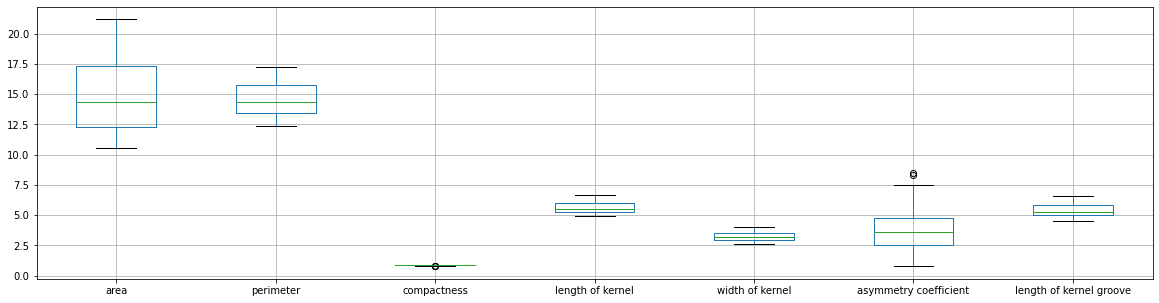

In [27]:
# Do we have any outliers? An outlier is an observation point that is distant from other observations - a boxplot is one of the most effective means of visualising outliers

df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

The asymmetry coefficient has the most notable/prominent outliers

## Data Preparation

We need to deal with the outliers in the 'asymmetry coefficient' attribute, and then we need to scale all of our data.